In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4);

import itertools
from numpy import sin, cos, pi

/Users/seanharnett/miniconda3/envs/p3/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def a_step(t, a, b, px, py):
    x, y = a*cos(t), b*sin(t)

    ex = (a*a - b*b) * cos(t)**3 / a
    ey = (b*b - a*a) * sin(t)**3 / b

    rx, ry = x - ex, y - ey
    qx, qy = px - ex, py - ey
    r, q = math.hypot(ry, rx), math.hypot(qy, qx)

    delta_c = r * math.asin((rx*qy - ry*qx)/(r*q))
    delta_t = delta_c / math.sqrt(a*a + b*b - x*x - y*y)
    return delta_t

In [4]:
TOL = 1e-12
T_MIN, T_START, T_MAX = 0, pi/4, pi/2
MAX_IT = 25

In [5]:
def f(t, a, b, x, y):
    return (x - a*cos(t))**2 + (y - b*sin(t))**2


def df(t, a, b, x, y):
    c2 = a**2 - b**2
    return 2*(a*x*sin(t) - b*y*cos(t) - c2*sin(t)*cos(t))


def d2f(t, a, b, x, y):
    c2 = a**2 - b**2
    return 2*(a*x*cos(t) + b*y*sin(t) - c2*cos(2*t))


def get_distance(a, b, x, y):
    if (x, y) == (0, 0): return min(a, b)
    x, y = abs(x), abs(y)
    t = T_START
    for i in range(MAX_IT):
        t_step = -df(t, a, b, x, y)/d2f(t, a, b, x, y)
        t = np.clip(t + t_step, T_MIN, T_MAX)
        if abs(t_step) < TOL: break 
    else:
        raise RuntimeError('Newton failed to converge in %d iterations' % MAX_IT)
    return f(t, a, b, x, y)**.5, i

In [6]:
def solve(a, b, px, py):  
    if (px, py) == (0, 0): return min(a, b)
    px, py = abs(px), abs(py)  
    t = T_START
    for i in range(MAX_IT):
        t_step = a_step(t, a, b, px, py)
        t = np.clip(t + t_step, T_MIN, T_MAX)
        if abs(t_step) < TOL: break
    else:
        raise RuntimeError('Special method failed to converge in %d iterations' % MAX_IT)
    return f(t, a, b, px, py)**.5, i

In [11]:
SPECIAL_ITS = 3
def hybrid(a, b, x, y):
    if (x, y) == (0, 0): return min(a, b)
    x, y = abs(x), abs(y)
    t = T_START
    for i in range(MAX_IT):
        t_step = (a_step(t, a, b, x, y) if i < SPECIAL_ITS
                  else -df(t, a, b, x, y)/d2f(t, a, b, x, y))
        t = np.clip(t + t_step, T_MIN, T_MAX)
        if abs(t_step) < TOL:
            return f(t, a, b, x, y)**.5, i
    else:
        raise RuntimeError('Failed to converge in %d iterations' % MAX_IT)
    return f(t, a, b, x, y)**.5, i

In [12]:
ddd, ddd2, ddd3 = [], [], []
for i in range(10000):
    a = 2*np.random.rand()
    b = 2*np.random.rand()
    x = 4*np.random.rand()-2
    y = 4*np.random.rand()-2
    ddd.append(get_distance(a, b, x, y)[1])
    ddd2.append(solve(a, b, x, y)[1])
    ddd3.append(hybrid(a, b, x, y)[1])  

In [13]:
ddd, ddd2, ddd3 = [], [], []
n = 50j
xmin, xmax, ymin, ymax = -320, 320, -320, 320
y, x = np.mgrid[ymin:ymax:n, xmin:xmax:n]
for _i, (a, b) in enumerate([(240, 120), (240, 200), (240, 40),
                             (240, 1), (1, 120), (120, 240),
                             (1, 2), (320, 240), (100, 100)]):
    for i, j in itertools.product(range(x.shape[0]), range(x.shape[1])):
        ddd.append(get_distance(a, b, x[i, j], y[i, j])[1])
        ddd2.append(solve(a, b, x[i, j], y[i, j])[1])
        ddd3.append(hybrid(a, b, x[i, j], y[i, j])[1])

In [14]:
pd.DataFrame(dict(newton=ddd, special=ddd2, hybrid=ddd3)).describe()

,hybrid,newton,special
count,22500.000000,22500.000000,22500.000000
mean,3.538489,4.062756,3.712533
std,1.191844,0.982250,1.553592
min,0.000000,0.000000,0.000000
25%,3.000000,3.000000,3.000000
50%,4.000000,4.000000,4.000000
75%,4.000000,5.000000,4.000000
max,7.000000,10.000000,11.000000


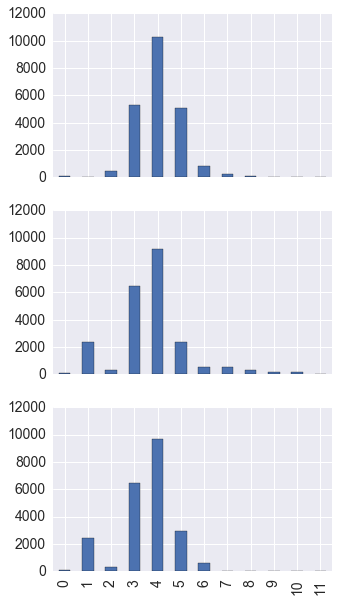

In [15]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(5, 10))
pd.Series(ddd).value_counts().reindex(range(12)).plot(kind='bar', ax=ax[0])
pd.Series(ddd2).value_counts().reindex(range(12)).plot(kind='bar', ax=ax[1])
pd.Series(ddd3).value_counts().reindex(range(12)).plot(kind='bar', ax=ax[2]);

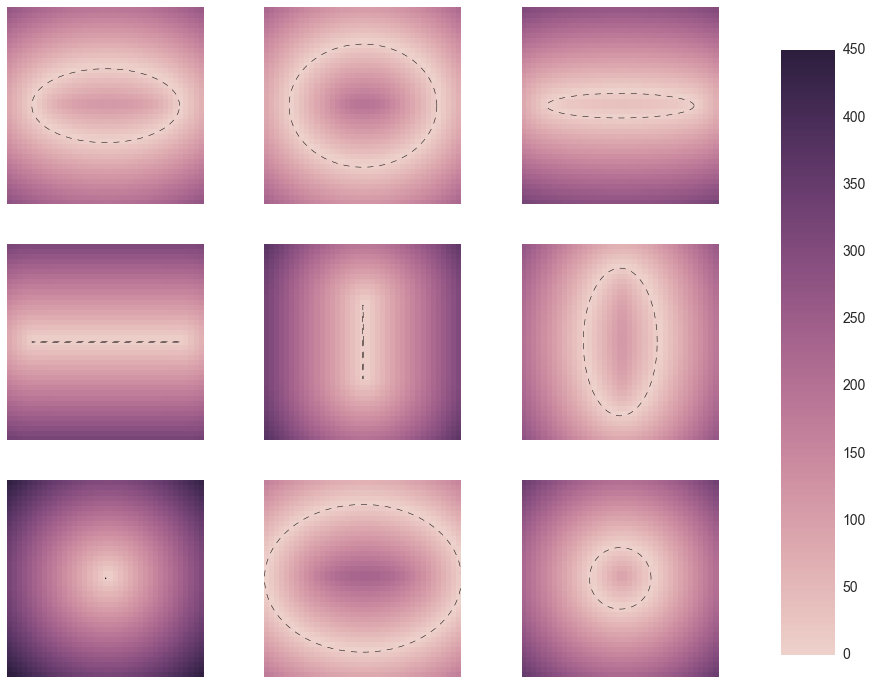

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))

n = 40j
xmin, xmax, ymin, ymax = -320, 320, -320, 320

y, x = np.mgrid[ymin:ymax:n, xmin:xmax:n]
z = np.empty_like(x)
t = np.linspace(0, 2*np.pi, 200)

for _i, (a, b) in enumerate([(240, 120), (240, 200), (240, 40),
                             (240, 1), (1, 120), (120, 240),
                             (1, 2), (320, 240), (100, 100)]):
    for i, j in itertools.product(range(x.shape[0]), range(x.shape[1])):
        z[i, j], _ = hybrid(a, b, x[i, j], y[i, j])
    
    ii, jj = _i//3, _i%3
    im = ax[ii, jj].pcolor(x, y, z, vmin=0, vmax=450, cmap=sns.cubehelix_palette(as_cmap=True))
    ax[ii, jj].plot(a*cos(t), b*sin(t), 'k--', lw=.5)

    ax[ii, jj].set_xlim(-320, 320)
    ax[ii, jj].set_ylim(-320, 320)
    ax[ii, jj].xaxis.set_ticks([])
    ax[ii, jj].yaxis.set_ticks([])
    ax[ii, jj].set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax);

# Arbitrary precision

It looks like the new method and Newton might be the same in the limit -- both converge quadratically.

In [65]:
from mpmath import mp
mp.dps = 200
DTOL = 1e-180

In [77]:
def df(t, a, b, x, y):
    c2 = a**2 - b**2
    return 2*(a*x*mp.sin(t) - b*y*mp.cos(t) - c2*mp.sin(t)*mp.cos(t))

def d2f(t, a, b, x, y):
    c2 = a**2 - b**2
    return 2*(a*x*mp.cos(t) + b*y*mp.sin(t) - c2*mp.cos(2*t))

In [78]:
a, b, x, y = 2, 1, 3, 5

In [79]:
t = T_START
for i in range(MAX_IT):
    t_step = -df(t, a, b, x, y)/d2f(t, a, b, x, y)
    t = np.clip(t + t_step, T_MIN, T_MAX)
    deriv = df(t, a, b, x, y)
    print('%2d %10.3g' % (i, deriv))
    if abs(deriv) < DTOL: break 

 0      0.052
 1   4.34e-05
 2   3.05e-11
 3   1.51e-23
 4   3.67e-48
 5   2.18e-97
 6  7.68e-196


In [91]:
def hypot(x, y):
    return mp.sqrt(x*x + y*y)

def a_step(t, a, b, px, py):
    x, y = a*mp.cos(t), b*mp.sin(t)

    ex = (a*a - b*b) * mp.cos(t)**3 / a
    ey = (b*b - a*a) * mp.sin(t)**3 / b

    rx, ry = x - ex, y - ey
    qx, qy = px - ex, py - ey
    r, q = hypot(ry, rx), hypot(qy, qx)

    delta_c = r * mp.asin((rx*qy - ry*qx)/(r*q))
    delta_t = delta_c / mp.sqrt(a*a + b*b - x*x - y*y)
    return delta_t

In [92]:
t = T_START
for i in range(MAX_IT):
    t_step = a_step(t, a, b, x, y)
    t = np.clip(t + t_step, T_MIN, T_MAX)
    deriv = df(t, a, b, x, y)
    print('%2d %10.3g' % (i, deriv))
    if abs(deriv) < DTOL: break 

 0    -0.0481
 1  -3.66e-05
 2   -2.1e-11
 3  -6.91e-24
 4  -7.49e-49
 5   -8.8e-99
 6 -1.21e-198
